In [1]:
## TODO refactor so that the actual disease name is the index in the df, and the numerical index corresponds to the cardinal index in nodelist

# Edge features 

### Load nodes

In [2]:
import pandas as pd 
import numpy as np

node_df = pd.read_csv('diseasome/diseases.csv')   # save this properly formatted 

In [3]:
node_df = node_df.set_index(node_df['Unnamed: 0']).drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
node_df.index.name = "node_id"
node_df.head()

,node2vec,gmvae,label,type
node_id,,,,
30.0,"[-0.465608, -0.382239, 0.12997, 0.470032, -0.2...","[-0.8235658407211304, 1.1888302564620972, -0.4...",Alzheimer disease,Neurological
36.0,"[-0.578018, -0.494388, 0.52027, 0.554174, -0.3...","[-1.607719898223877, -0.41855698823928833, -0....",Cerebral amyloid angiopathy,Neurological
37.0,"[-0.554796, -0.479376, 0.511476, 0.547988, -0....","[-2.5158896446228027, -0.44234979152679443, -0...",Coronary artery disease,Cardiovascular
38.0,"[-0.594653, -0.491095, 0.508405, 0.581627, -0....","[-1.138237476348877, 0.09204845130443573, -0.6...",HDL cholesterol level QTL,Metabolic
39.0,"[-0.562435, -0.494444, 0.494899, 0.551595, -0....","[0.19286823272705078, -0.024575497955083847, -...",Tangier disease,Metabolic


In [4]:
node_df['node2vec'] = node_df['node2vec'].apply(lambda x: np.fromstring(x.replace('[', '').replace(']', ''), sep=','))
node_df['gmvae'] = node_df['gmvae'].apply(lambda x: np.fromstring(x.replace('[', '').replace(']', ''), sep=','))

### Compute edge features

In [5]:
import numpy as np

with open('diseasome/disease_network_edgelist_weighted.txt') as f: 
    edgelist = [[int(i) for i in l.replace('\n', '').split(' ')] for l in f.readlines()]
    
edge_weigths = [e[2] for e in edgelist]
edgelist = np.array([e[:2] for e in edgelist])
edgelist.shape

(1188, 2)

In [6]:
edgelist

array([[818,  55],
       [818, 819],
       [818, 820],
       ...,
       [841,  30],
       [ 30,  99],
       [441, 491]])

In [7]:
### TODO do this 

In [8]:
adj = np.zeros((len(node_df), len(node_df)))
adj[edgelist[:,0], edgelist[:, 1]] = 1

IndexError: index 818 is out of bounds for axis 0 with size 516

### Sample negative edges

In [9]:
e = [list(i) for i in edgelist]

In [10]:
import random 

nodes = list(node_df.index)
negative_edgelist = []

while len(negative_edgelist) < len(edgelist):
    u, v = random.choice(nodes), random.choice(nodes)
    if u != v:
        if [u, v] not in e:
            negative_edgelist.append(np.array([u, v]))

In [11]:
negative_edgelist = np.stack(negative_edgelist)

In [12]:
# hadamard feature for the edges 
n2v_features = np.multiply(np.stack(node_df.loc[edgelist[:, 0]]['node2vec'].values), 
                           np.stack(node_df.loc[edgelist[:, 1]]['node2vec'].values))
n2v_features_neg = np.multiply(np.stack(node_df.loc[negative_edgelist[:, 0]]['node2vec'].values), 
                           np.stack(node_df.loc[negative_edgelist[:, 1]]['node2vec'].values))

gmvae_features = np.multiply(np.stack(node_df.loc[edgelist[:, 0]]['gmvae'].values), 
                            np.stack(node_df.loc[edgelist[:, 1]]['gmvae'].values))
gmvae_features_neg = np.multiply(np.stack(node_df.loc[negative_edgelist[:, 0]]['gmvae'].values), 
                            np.stack(node_df.loc[negative_edgelist[:, 1]]['gmvae'].values))

### Plot them

#### node2vec

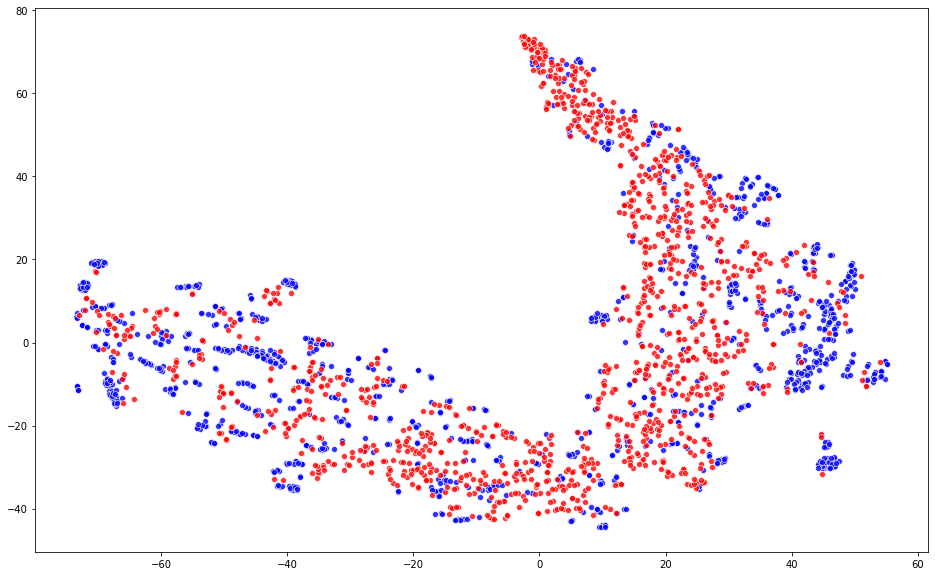

In [13]:
# add tsne to the df
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import seaborn as sns 

n2v_edge_proj = TSNE(n_components=2).fit_transform(np.vstack([n2v_features, n2v_features_neg]))

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=n2v_edge_proj[:len(edgelist), 0], y=n2v_edge_proj[:len(edgelist), 1],
    palette=sns.color_palette("hls", 10),
    legend='full', 
    alpha=0.8,
    color='blue'
)
sns.scatterplot(
    x=n2v_edge_proj[len(edgelist):, 0], y=n2v_edge_proj[len(edgelist):, 1],
    palette=sns.color_palette("hls", 10),
    legend='full', 
    alpha=0.8,
    color='red'
)

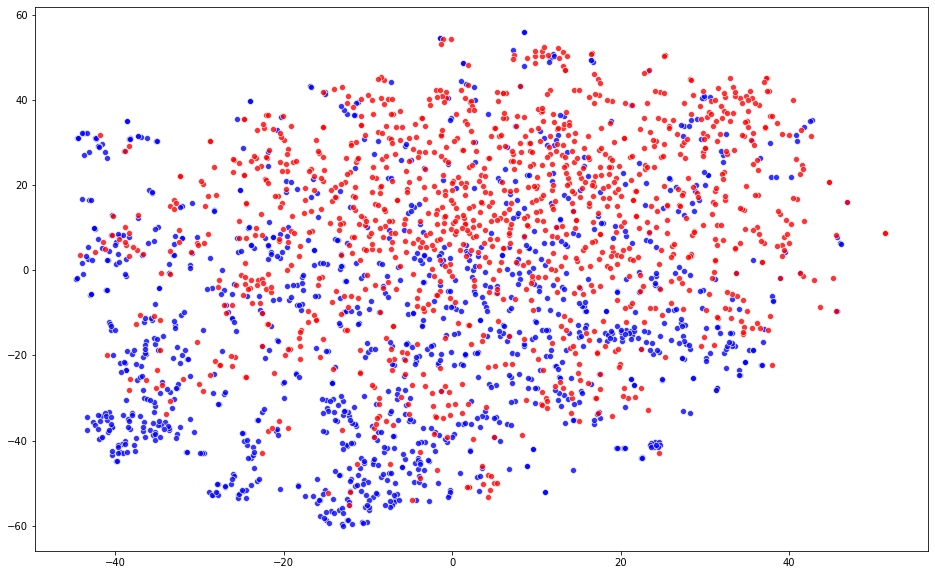

In [14]:
gmvae_edge_proj = TSNE(n_components=2).fit_transform(np.vstack([gmvae_features, gmvae_features_neg]))

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=gmvae_edge_proj[:len(edgelist), 0], y=gmvae_edge_proj[:len(edgelist), 1],
    palette=sns.color_palette("hls", 10),
    legend='full', 
    alpha=0.8,
    color='blue'
)
sns.scatterplot(
    x=gmvae_edge_proj[len(edgelist):, 0], y=gmvae_edge_proj[len(edgelist):, 1],
    palette=sns.color_palette("hls", 10),
    legend='full', 
    alpha=0.8,
    color='red'
)

# Link prediction

## Model

In [164]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_link_predictor():
    return keras.Sequential(
    [
        layers.Dense(64, activation="relu", name="layer1"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu", name="layer2"),
        layers.Dropout(0.2),
        layers.Dense(1, activation=None, name="layer3"),
    ]
)

## Train functions 

In [165]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [174]:
class Trainer:
    
    def __init__(self, model, train_ds, test_ds):
        self.model = model
        self.train_ds = train_ds
        self.test_ds = test_ds
        
        self.train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
        self.train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
        self.test_loss_metric = tf.keras.metrics.Mean(name='test_loss')
        self.test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
        
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.optimizer = tf.keras.optimizers.Adam()
        
    @tf.function 
    def train_step(self, x, y): 
        with tf.GradientTape() as tape: 
            y_ = self.model(x, training=True)
            loss = self.bce(y, y_)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.train_loss_metric(loss)
        self.train_accuracy(y, y_)

    @tf.function
    def test_step(self, x, y):
        y_ = self.model(x, training=False)
        t_loss = self.bce(y, y_)

        self.test_loss_metric(t_loss)
        self.test_accuracy(y, y_)
        
    def train(self, epochs=200):
        test_accuracies = []
        for epoch in range(epochs):
            # Reset the metrics at the start of the next epoch
            self.train_loss_metric.reset_states()
            self.test_loss_metric.reset_states()

            for x, y in self.train_ds:
                self.train_step(x, y)

            for x_test, y_test in self.test_ds:
                self.test_step(x_test, y_test)

            if epoch % 50 == 0:
                print('epoch', epoch)
                print('train loss', self.train_loss_metric.result().numpy(), 'train accuracy', self.train_accuracy.result().numpy())
                print('test loss', self.test_loss_metric.result().numpy(), 'test accuracy', self.test_accuracy.result().numpy())
            test_accuracies.append(self.test_accuracy.result().numpy())
        return test_accuracies


### node2vec

In [175]:
# labels = np.array(edge_weigths + [0 for i in range(len(edgelist))])    # TODO take into accont the weight of the edge, make this a regression problem 
labels = np.concatenate((np.ones((len(edgelist))), np.zeros((len(edgelist)))))
n2v_data = np.vstack([n2v_features, n2v_features_neg])

In [176]:
from sklearn.model_selection import train_test_split

n2v_x_train, n2v_x_test, n2v_y_train, n2v_y_test = train_test_split(n2v_data, labels, test_size=0.1, random_state=42)

In [177]:
n2v_train_ds = tf.data.Dataset.from_tensor_slices((n2v_x_train, n2v_y_train)).shuffle(10000).batch(128)
n2v_test_ds = tf.data.Dataset.from_tensor_slices((n2v_x_test, n2v_y_test)).shuffle(10000).batch(128)

In [178]:
n2v_link_predictor = build_link_predictor()
n2v_trainer = Trainer(n2v_link_predictor, n2v_train_ds, n2v_test_ds)
n2v_accuracy = n2v_trainer.train(epochs=500)

epoch 0
train loss 1.1415576 train accuracy 0.51647264
test loss 0.69744146 test accuracy 0.5397017
epoch 50
train loss 0.66946775 train accuracy 0.5140258
test loss 0.65566397 test accuracy 0.527185
epoch 100
train loss 0.42926067 train accuracy 0.5963918
test loss 0.41746458 test accuracy 0.60681546
epoch 150
train loss 0.31758767 train accuracy 0.67492646
test loss 0.26679447 test accuracy 0.68804914
epoch 200
train loss 0.2503031 train accuracy 0.7264867
test loss 0.2085977 test accuracy 0.7448203
epoch 250
train loss 0.21653815 train accuracy 0.7617689
test loss 0.17475358 test accuracy 0.78322625
epoch 300
train loss 0.19693767 train accuracy 0.78698593
test loss 0.15961623 test accuracy 0.80951595
epoch 350
train loss 0.19551231 train accuracy 0.80623394
test loss 0.16964318 test accuracy 0.8289879
epoch 400
train loss 0.18463002 train accuracy 0.8215395
test loss 0.15203999 test accuracy 0.8441459
epoch 450
train loss 0.17026716 train accuracy 0.8339797
test loss 0.14775524 tes

### gmvae

In [179]:
# labels = np.array(edge_weigths + [0 for i in range(len(edgelist))])    # TODO take into accont the weight of the edge, make this a regression problem 
labels = np.concatenate((np.ones((len(edgelist))), np.zeros((len(edgelist)))))
gmvae_data = np.vstack([gmvae_features, gmvae_features_neg])

gmvae_x_train, gmvae_x_test, gmvae_y_train, gmvae_y_test = train_test_split(gmvae_data, labels, test_size=0.1, random_state=42)

gmvae_train_ds = tf.data.Dataset.from_tensor_slices((gmvae_x_train, gmvae_y_train)).shuffle(10000).batch(128)
gmvae_test_ds = tf.data.Dataset.from_tensor_slices((gmvae_x_test, gmvae_y_test)).shuffle(10000).batch(128)

In [180]:
gmvae_link_predictor = build_link_predictor()
gmvae_trainer = Trainer(gmvae_link_predictor, gmvae_train_ds, gmvae_test_ds)
gmvae_accuracy = gmvae_trainer.train(epochs=500)

epoch 0
train loss 0.6878409 train accuracy 0.52244693
test loss 0.6584369 test accuracy 0.58842325
epoch 50
train loss 0.4163475 train accuracy 0.772125
test loss 0.55553627 test accuracy 0.73222613
epoch 100
train loss 0.3765881 train accuracy 0.7921831
test loss 0.5699396 test accuracy 0.7349522
epoch 150
train loss 0.34692928 train accuracy 0.80428946
test loss 0.57499135 test accuracy 0.73718643
epoch 200
train loss 0.3282576 train accuracy 0.8133474
test loss 0.5906409 test accuracy 0.7385636
epoch 250
train loss 0.295552 train accuracy 0.8210815
test loss 0.61373866 test accuracy 0.73888046
epoch 300
train loss 0.29365647 train accuracy 0.82780075
test loss 0.6271424 test accuracy 0.7390874
epoch 350
train loss 0.26906532 train accuracy 0.833425
test loss 0.6314844 test accuracy 0.74019814
epoch 400
train loss 0.27148482 train accuracy 0.8383358
test loss 0.64228606 test accuracy 0.7411705
epoch 450
train loss 0.25703508 train accuracy 0.8428112
test loss 0.6442454 test accuracy

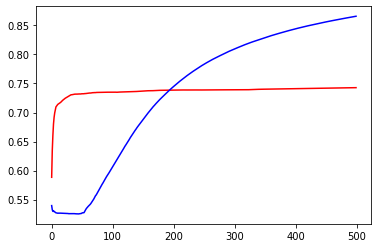

In [181]:
plt.plot(gmvae_accuracy, color='red')
plt.plot(n2v_accuracy, color='blue')

In [183]:
# TODO compare with vanilla graph VAE (check paper results)
# TODO compare with dataset used in graph vae paper 
# TODO play around with model parameters, and compare here 
# TODO check out KL divergence computation -> this is being sampled. 
